# Calibration

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("s3://crisk-nico-prod/predictions/raw/raw_predictions.csv")
data.head()

,SK_ID_CURR,pd_raw,TARGET
0,100008,0.458761,0
1,100016,0.576370,0
2,100024,0.668503,0
3,100032,0.421879,0
4,100040,0.456684,0


Now, lets evaluate again AUC in data without calibrating, to make sure sanity of the model, and this time we implement Brief Score Loss to measure the accuracy of probability predictions: 

$Brief Score = \frac{1}{N} \sum_{i=1}^N(p_i-y_i)^2$

It measures how close the predicted probability is to te actual true value.

In [2]:
from sklearn.metrics import roc_auc_score, brier_score_loss

ytrain = data["TARGET"].values
p_raw_train = data["pd_raw"].values

auc_raw = roc_auc_score(ytrain, p_raw_train)
brier_raw = brier_score_loss(ytrain, p_raw_train)

print(f"Baseline AUC (raw):   {auc_raw:.4f}")
print(f"Baseline Brier (raw): {brier_raw:.4f}")


Baseline AUC (raw):   0.7433
Baseline Brier (raw): 0.2093


We’ll use X_train, y_train to fit the calibrators, and X_val, y_val to evaluate calibration quality.

In [3]:
from sklearn.model_selection import train_test_split

X_raw = p_raw_train.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, ytrain, test_size=0.2, random_state=42, stratify=ytrain
)

print(X_train.shape, X_test.shape)


(246008, 1) (61503, 1)


## Why do we need Calibration

Most of the model can produce scores or probabilities, but the predicted probability obtained by `predict_proba()` is not often equal to the real-world probability.
For example, a model may say probability of default is 0.20, but in reality among clients with similar characteristics only exist 10% default, so the model is **miscalibrated** (easier to understand visually through the calibrate curves fom raw vs iso vs platt data).

### Platt Scaling (Sigmoid Calibration)

Platt Scaling fits a small logistic regression on the model’s raw scores to convert them into calibrated probabilities.

In [4]:
from sklearn.linear_model import LogisticRegression

eps = 1e-6

def to_logit(p):
    p = np.clip(p, eps, 1-eps)
    return np.log(p / (1 - p))

logit_train = to_logit(X_train.ravel()).reshape(-1,1)
logit_test  = to_logit(X_test.ravel()).reshape(-1,1)

platt = LogisticRegression()
platt.fit(logit_train, y_train)

pd_platt_test = platt.predict_proba(logit_test)[:, 1]


### Isotonic Regression (Non-parametric Calibration)

Isotonic regression fits a monotonic (always increasing) curve that maps the raw scores to calibrated PDs.
Instead of a fixed functional form (like sigmoid), it learns a step-wise function directly from the data.

In [5]:
from sklearn.isotonic import IsotonicRegression

iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(X_train.ravel(), y_train)

pd_iso_test = iso.transform(X_test.ravel())


## Compare Calibration

Compare AUC and Brier of every method.

In [6]:
def eval_calib(name, y_true, p):
    auc = roc_auc_score(y_true, p)
    brier = brier_score_loss(y_true, p)
    print(f"{name:10s} | AUC = {auc:.4f} | Brier = {brier:.4f}")

print("Calibration comparison on test split:")
eval_calib("raw",   y_test, X_test.ravel())
eval_calib("platt", y_test, pd_platt_test)
eval_calib("iso",   y_test, pd_iso_test)


Calibration comparison on test split:
raw        | AUC = 0.7426 | Brier = 0.2082
platt      | AUC = 0.7426 | Brier = 0.0688
iso        | AUC = 0.7425 | Brier = 0.0688


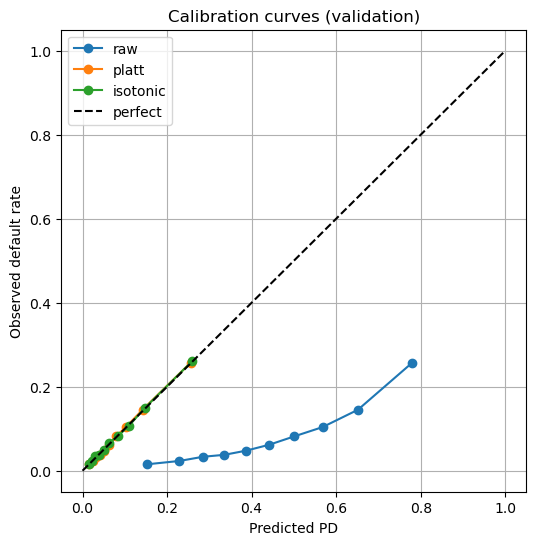

In [7]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(6,6))

for p, label in [
    (X_test.ravel(), "raw"),
    (pd_platt_test, "platt"),
    (pd_iso_test, "isotonic")
]:
    frac_pos, mean_pred = calibration_curve(y_test, p, n_bins=10, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker="o", label=label)

plt.plot([0,1],[0,1],"k--", label="perfect")
plt.xlabel("Predicted PD")
plt.ylabel("Observed default rate")
plt.title("Calibration curves (validation)")
plt.legend()
plt.grid(True)
plt.show()


We will use **Platt Calibration** method because shows a little better performance.

## Fit Calibrator on all raw data

In [8]:
logit_train = to_logit(p_raw_train.ravel()).reshape(-1,1)

platt = LogisticRegression()
platt.fit(logit_train, ytrain)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [9]:
data["pd_calibrated"] = platt.predict_proba(logit_train)[:, 1]

In [10]:
# iso_final = IsotonicRegression(out_of_bounds="clip")
# iso_final.fit(p_raw_train, ytrain)

# data["pd_calibrated"] = iso_final.transform(p_raw_train)

# Band Scores

For create a band score, we will use a monotonic score, to get:

$Score = -ln(Probability_{default})$

* Lower probability of default means higher score.
* Higher probability of default means lower score.

In [11]:
data["score"] = -np.log(data["pd_calibrated"])
data

,SK_ID_CURR,pd_raw,TARGET,pd_calibrated,score
0,100008,0.458761,0,0.067270,2.699038
1,100016,0.576370,0,0.105572,2.248367
2,100024,0.668503,0,0.150953,1.890787
3,100032,0.421879,0,0.058126,2.845148
4,100040,0.456684,0,0.066726,2.707163
...,...,...,...,...,...
307506,456215,0.523120,1,0.086199,2.451101
307507,456231,0.724931,0,0.190224,1.659551
307508,456239,0.364694,0,0.045866,3.082028
307509,456247,0.352585,0,0.043527,3.134380


Now, for band assignment we should select threshold ranges. As starting point we choose this threshold:

| Band | PD Range      |
| ---- | ------------- |
| A    | [0.00 – 0.01] |
| B    | (0.01 – 0.03] |
| C    | (0.03 – 0.07] |
| D    | (0.07 – 0.15] |
| E    | (0.15 – 1.00] |


In [12]:
bins = [0.0, 0.01, 0.03, 0.07, 0.15, 1.0]
labels = ["A", "B", "C", "D", "E"]

data["band"] = pd.cut(data["pd_calibrated"], bins=bins, labels=labels, right=True)
data


,SK_ID_CURR,pd_raw,TARGET,pd_calibrated,score,band
0,100008,0.458761,0,0.067270,2.699038,C
1,100016,0.576370,0,0.105572,2.248367,D
2,100024,0.668503,0,0.150953,1.890787,E
3,100032,0.421879,0,0.058126,2.845148,C
4,100040,0.456684,0,0.066726,2.707163,C
...,...,...,...,...,...,...
307506,456215,0.523120,1,0.086199,2.451101,D
307507,456231,0.724931,0,0.190224,1.659551,E
307508,456239,0.364694,0,0.045866,3.082028,C
307509,456247,0.352585,0,0.043527,3.134380,C


## Test monotonicity

Lets check monotonicity behavior, increasing from band A to E:

$Band A < Band B < Band C < Band D < Band E$

In [13]:
band_stats = data.groupby("band", observed=False)["pd_calibrated"].mean()
print(band_stats)


band
A    0.007790
B    0.021030
C    0.047801
D    0.101409
E    0.232459
Name: pd_calibrated, dtype: float64


## Full scorecard table

In [14]:
scorecard = data.groupby("band", observed=False).agg(
    min_pd     = ("pd_calibrated", "min"),
    max_pd     = ("pd_calibrated", "max"),
    avg_pd     = ("pd_calibrated", "mean"),
    avg_target   = ("TARGET", "mean"),
    avg_score  = ("score", "mean"),
    min_score  = ("score", "min"),
    max_score  = ("score", "max"),
    count      = ("SK_ID_CURR", "count"),
).reset_index()

scorecard = scorecard.sort_values("band")
scorecard


,band,min_pd,max_pd,avg_pd,avg_target,avg_score,min_score,max_score,count
0,A,4.864906e-08,0.009999,0.007790,0.011152,4.913209,4.605261,16.838633,4304
1,B,1.000062e-02,0.030000,0.021030,0.020392,3.899054,3.506559,4.605108,65614
2,C,3.000004e-02,0.069999,0.047801,0.046126,3.069306,2.659280,3.506557,112972
3,D,7.000121e-02,0.149996,0.101409,0.104085,2.312089,1.897146,2.659243,83480
4,E,1.500019e-01,0.999868,0.232459,0.231861,1.508872,0.000132,1.897107,41141


Save to CSV for downstream steps.

In [15]:
CALIBRATED = "s3://crisk-nico-prod/predictions/calibrated/calibrated_predictions.parquet"
out_cols = ["SK_ID_CURR", "TARGET", "pd_calibrated", "band", "score"]

data[out_cols].to_parquet(CALIBRATED, index=False)

# Summary

To transform continuous predicted probabilities of default (PD) into meaningful and interpretable credit risk categories, the model assigns each customer to a Scoreband (A–E). Scorebands enable:

* Clear segmentation of applicants by risk level.
* Transparent decision rules for credit strategy.
* Portfolio monitoring of risk migration over time.
* Alignment with internal risk appetite and policy.

Scorebands simplify communication with business teams, allowing risk managers to discuss the customer base in discrete risk buckets rather than raw probabilities. This segmentation enables clear credit decision rules, supports portfolio management, and aligns with industry best practices for PD modeling. The banding structure (A–E) shows strong monotonicity and calibration, ensuring that higher bands truly represent higher risk and can be interpreted with confidence by risk managers and business stakeholders.